In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

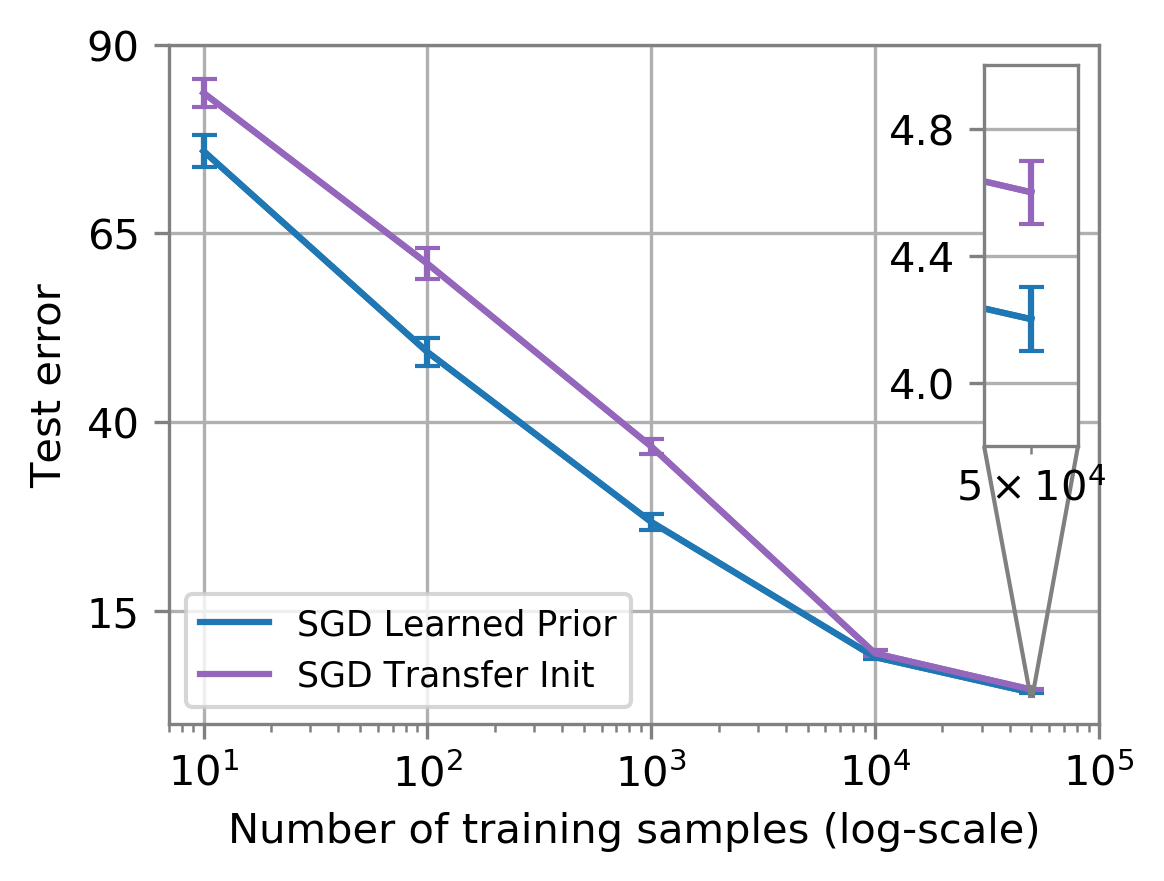

In [2]:
def color_ax(ax, color='gray'):
    ax.grid()
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)
    
def plot_figure_4a(ax):
    # Reported values in Pre-Train Your Loss
    ax.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    ax.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    ax.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    ax.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    # Zoomed section
    axins = zoomed_inset_axes(ax, zoom=42, loc='upper right')
    axins.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='SGD Learned Prior', color='#1f77b4')
    axins.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    axins.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='SGD Transfer Init', color='#9467bd')
    axins.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    axins.set_xlim([49425, 50575])
    axins.set_ylim([3.8, 5.0])
    axins.set_yticks([4.0, 4.4, 4.8])
    axins.set_xscale('log')
    color_ax(axins)
    mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
    # Formatting
    ax.set_xlim([7, 1e5])
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.set_yticks([15, 40, 65, 90])
    ax.set_xscale('log')
    color_ax(ax)
    ax.set_xlabel('Number of training samples (log-scale)')
    ax.set_ylabel('Test error')
    ax.legend(loc='lower left', fontsize='small')
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
plot_figure_4a(ax)
plt.show()

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_loss(df):
    return df.val_or_test_loss.values[-1]

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

In [4]:
def get_nonlearned_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays):
    columns = ['lr_0', 'n', 'random_state', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_loss = np.inf
        best_hyperparameters = None
        for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
            model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
            .format(lr_0, n, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_loss = get_val_loss(get_df(path))
            if val_loss < best_val_loss: best_val_loss = val_loss; best_hyperparameters = [lr_0, n, random_state, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df
    
def get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'random_state', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, random_state in itertools.product(ns, random_states):
        best_val_nll = np.inf
        best_hyperparameters = None
        for prior_scale in prior_scales:
            best_val_loss = np.inf
            best_model_name = None
            best_lr_0 = None
            best_weight_decay = None
            for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
                model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
                .format(lr_0, n, prior_scale, random_state, weight_decay)
                path =  '{}/{}.csv'.format(experiments_path, model_name)
                val_loss = get_val_loss(get_df(path))
                if val_loss < best_val_loss: best_val_loss = val_loss; best_model_name = model_name; best_lr_0 = lr_0; best_weight_decay = weight_decay
            path = '{}/{}.csv'.format(experiments_path, best_model_name)
            val_nll = get_val_nll(get_df(path))
            if val_nll < best_val_nll: best_val_nll = val_nll; best_hyperparameters = [best_lr_0, n, prior_scale, random_state, best_weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

def get_nonlearned_results(df, experiments_path):
    columns = ['n', 'random_state', 'method', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior']
    results = pd.DataFrame(columns=columns)
    for row_index, row in df.iterrows():
        model_name = 'nonlearned_lr_0={}_n={}_random_state={}_weight_decay={}'\
        .format(row.lr_0, int(row.n), int(row.random_state), row.weight_decay)
        path =  '{}/{}.csv'.format(experiments_path, model_name)
        last_epoch = get_last_epoch(get_df(path))
        results_row = [int(row.n), int(row.random_state), 'nonlearned', 
                       last_epoch.val_or_test_acc, last_epoch.val_or_test_loss, 
                       last_epoch.val_or_test_nll, last_epoch.val_or_test_prior, 
                       last_epoch.train_acc, last_epoch.train_loss, 
                       last_epoch.train_nll, last_epoch.train_prior]
        results.loc[results.shape[0]] = results_row
    return results

def get_learned_results(df, experiments_path):
    columns = ['n', 'random_state', 'method', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior']
    results = pd.DataFrame(columns=columns)
    for row_index, row in df.iterrows():
        model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
        .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
        path =  '{}/{}.csv'.format(experiments_path, model_name)
        last_epoch = get_last_epoch(get_df(path))
        results_row = [int(row.n), int(row.random_state), 'learned', 
                       last_epoch.val_or_test_acc, last_epoch.val_or_test_loss, 
                       last_epoch.val_or_test_nll, last_epoch.val_or_test_prior, 
                       last_epoch.train_acc, last_epoch.train_loss, 
                       last_epoch.train_nll, last_epoch.train_prior]
        results.loc[results.shape[0]] = results_row
    return results

In [5]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [10, 100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
nonlearned_hyperparameters = get_nonlearned_hyperparameters(experiments_path, lr_0s, ns, random_states, weight_decays)
nonlearned_hyperparameters

,lr_0,n,random_state,weight_decay
0,0.0001,10.0,1001.0,0.00010
1,0.0100,10.0,2001.0,0.00100
2,0.0010,10.0,3001.0,0.01000
3,0.0001,100.0,1001.0,0.00001
4,0.0001,100.0,2001.0,0.00010
5,0.0001,100.0,3001.0,0.00100
6,0.0100,1000.0,1001.0,0.00100
7,0.0100,1000.0,2001.0,0.00100
8,0.0100,1000.0,3001.0,0.00001
9,0.0100,10000.0,1001.0,0.00100


In [30]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [1000, 50000]
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
learned_hyperparameters = get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays)
learned_hyperparameters

,lr_0,n,prior_scale,random_state,weight_decay
0,0.010,1000.0,100000000.0,1001.0,0.00100
1,0.010,1000.0,100000.0,2001.0,0.00001
2,0.010,1000.0,10.0,3001.0,0.00001
3,0.010,50000.0,100000.0,1001.0,0.00100
4,0.001,50000.0,100000.0,2001.0,0.01000
5,0.001,50000.0,100000000.0,3001.0,0.01000


In [31]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in learned_hyperparameters.iterrows():
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
    if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
        count += 1
        print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --wandb --weight_decay={}"'\
              .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, int(row.random_state), row.weight_decay))
print(count)

-1


In [32]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
nonlearned_results = get_nonlearned_results(nonlearned_hyperparameters, experiments_path)
learned_results = get_learned_results(learned_hyperparameters, experiments_path)
results = pd.concat([nonlearned_results, learned_results])
#results = nonlearned_results
results

,n,random_state,method,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior
0,10,1001,nonlearned,0.314585,1.993855,1.993855,0.000000,1.000000,0.004884,0.004884,0.000000
1,10,2001,nonlearned,0.262714,2.171446,2.171446,0.000000,1.000000,0.000158,0.000158,0.000000
2,10,3001,nonlearned,0.256007,2.136913,2.136913,0.000000,1.000000,0.001504,0.001504,0.000000
3,100,1001,nonlearned,0.547119,1.434934,1.434934,0.000000,1.000000,0.009884,0.009884,0.000000
4,100,2001,nonlearned,0.556731,1.410616,1.410616,0.000000,1.000000,0.008884,0.008884,0.000000
5,100,3001,nonlearned,0.573320,1.302814,1.302814,0.000000,1.000000,0.008902,0.008902,0.000000
6,1000,1001,nonlearned,0.827303,0.634889,0.634889,0.000000,1.000000,0.000093,0.000093,0.000000
7,1000,2001,nonlearned,0.825939,0.634948,0.634948,0.000000,1.000000,0.000090,0.000090,0.000000
8,1000,3001,nonlearned,0.823771,0.733389,0.733389,0.000000,1.000000,0.000009,0.000009,0.000000
9,10000,1001,nonlearned,0.934479,0.227405,0.227405,0.000000,1.000000,0.000147,0.000147,0.000000


In [33]:
# TODO: If more seeds are added average over seeds
grouped_results = results.groupby(['n', 'method']).agg(lambda x: tuple(x))
columns = ['test_acc', 'train_acc']
for column in columns:
    grouped_results['{}_mean'.format(column)] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results['{}_std'.format(column)] = grouped_results[column].apply(lambda item: np.std(item))
grouped_results = grouped_results.reset_index()
grouped_results

,n,method,random_state,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior,test_acc_mean,test_acc_std,train_acc_mean,train_acc_std
0,10,nonlearned,"(1001, 2001, 3001)","(0.314584617901, 0.262713941574, 0.256007477868)","(1.993854669, 2.17144612923, 2.13691278267)","(1.993854669, 2.17144612923, 2.13691278267)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00488359760493, 0.000157867951202, 0.001504...","(0.00488359760493, 0.000157867951202, 0.001504...","(0.0, 0.0, 0.0)",0.277769,0.026176,1.000000,0.000000e+00
1,100,nonlearned,"(1001, 2001, 3001)","(0.547118593311, 0.556731097937, 0.573320147514)","(1.43493428154, 1.41061631756, 1.30281434135)","(1.43493428154, 1.41061631756, 1.30281434135)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(0.00988360028714, 0.00888423901051, 0.0089023...","(0.00988360028714, 0.00888423901051, 0.0089023...","(0.0, 0.0, 0.0)",0.559057,0.010822,1.000000,0.000000e+00
2,1000,learned,"(1001, 2001, 3001)","(0.821055980778, 0.836523625469, 0.84777664032)","(11497.5411328, 3445.41358516, -537.968620898)","(0.66123499279, 0.654311614132, 0.553170759869)","(-11496.8798828, -3444.75927734, 538.521789551)","(1.00000011921, 1.00000011921, 1.00000011921)","(114968.796875, 34447.59375, -5385.21777344)","(8.94441616256e-05, 1.36144815187e-05, 0.00021...","(-114968.796875, -34447.59375, 5385.21777344)",0.835119,0.010954,1.000000,0.000000e+00
3,1000,nonlearned,"(1001, 2001, 3001)","(0.827302546978, 0.825938643932, 0.823771187592)","(0.634888745594, 0.634948437595, 0.733388891888)","(0.634888745594, 0.634948437595, 0.733388891888)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011921, 1.00000011921)","(9.34593027923e-05, 9.0175187157e-05, 8.721581...","(9.34593027923e-05, 9.0175187157e-05, 8.721581...","(0.0, 0.0, 0.0)",0.825671,0.001454,1.000000,0.000000e+00
4,10000,nonlearned,"(1001, 2001, 3001)","(0.934479172516, 0.934396427917, 0.935066081238)","(0.227405305862, 0.236420504332, 0.234736738396)","(0.227405305862, 0.236420504332, 0.234736738396)","(0.0, 0.0, 0.0)","(1.00000011921, 1.00000011902, 1.00000011902)","(0.000146721560587, 0.000147643644176, 0.00014...","(0.000146721560587, 0.000147643644176, 0.00014...","(0.0, 0.0, 0.0)",0.934647,0.000298,1.000000,8.991323e-11
5,50000,learned,"(1001, 2001, 3001)","(0.966218100739, 0.966822396851, 0.966872816467)","(3444.87199141, 3444.87301406, 11496.9914906)","(0.108803520137, 0.112997391012, 0.111641027653)","(-3444.76318359, -3444.76000977, -11496.8798828)","(0.999980426826, 0.999922700996, 0.999865746651)","(688.953823086, 688.956144023, 2299.3798182)","(0.00118601581508, 0.00412013060227, 0.0038403...","(-688.952636719, -688.952026367, -2299.37597656)",0.966638,0.000297,0.999923,4.681834e-05
6,50000,nonlearned,"(1001, 2001, 3001)","(0.967178112793, 0.966439698792, 0.968881274414)","(0.108847916961, 0.112230469608, 0.108662848991)","(0.108847916961, 0.112230469608, 0.108662848991)","(0.0, 0.0, 0.0)","(0.999968359718, 0.999880782661, 0.99988292408)","(0.00124783313295, 0.00407723529592, 0.0038411...","(0.00124783313295, 0.00407723529592, 0.0038411...","(0.0, 0.0, 0.0)",0.967500,0.001022,0.999911,4.078885e-05


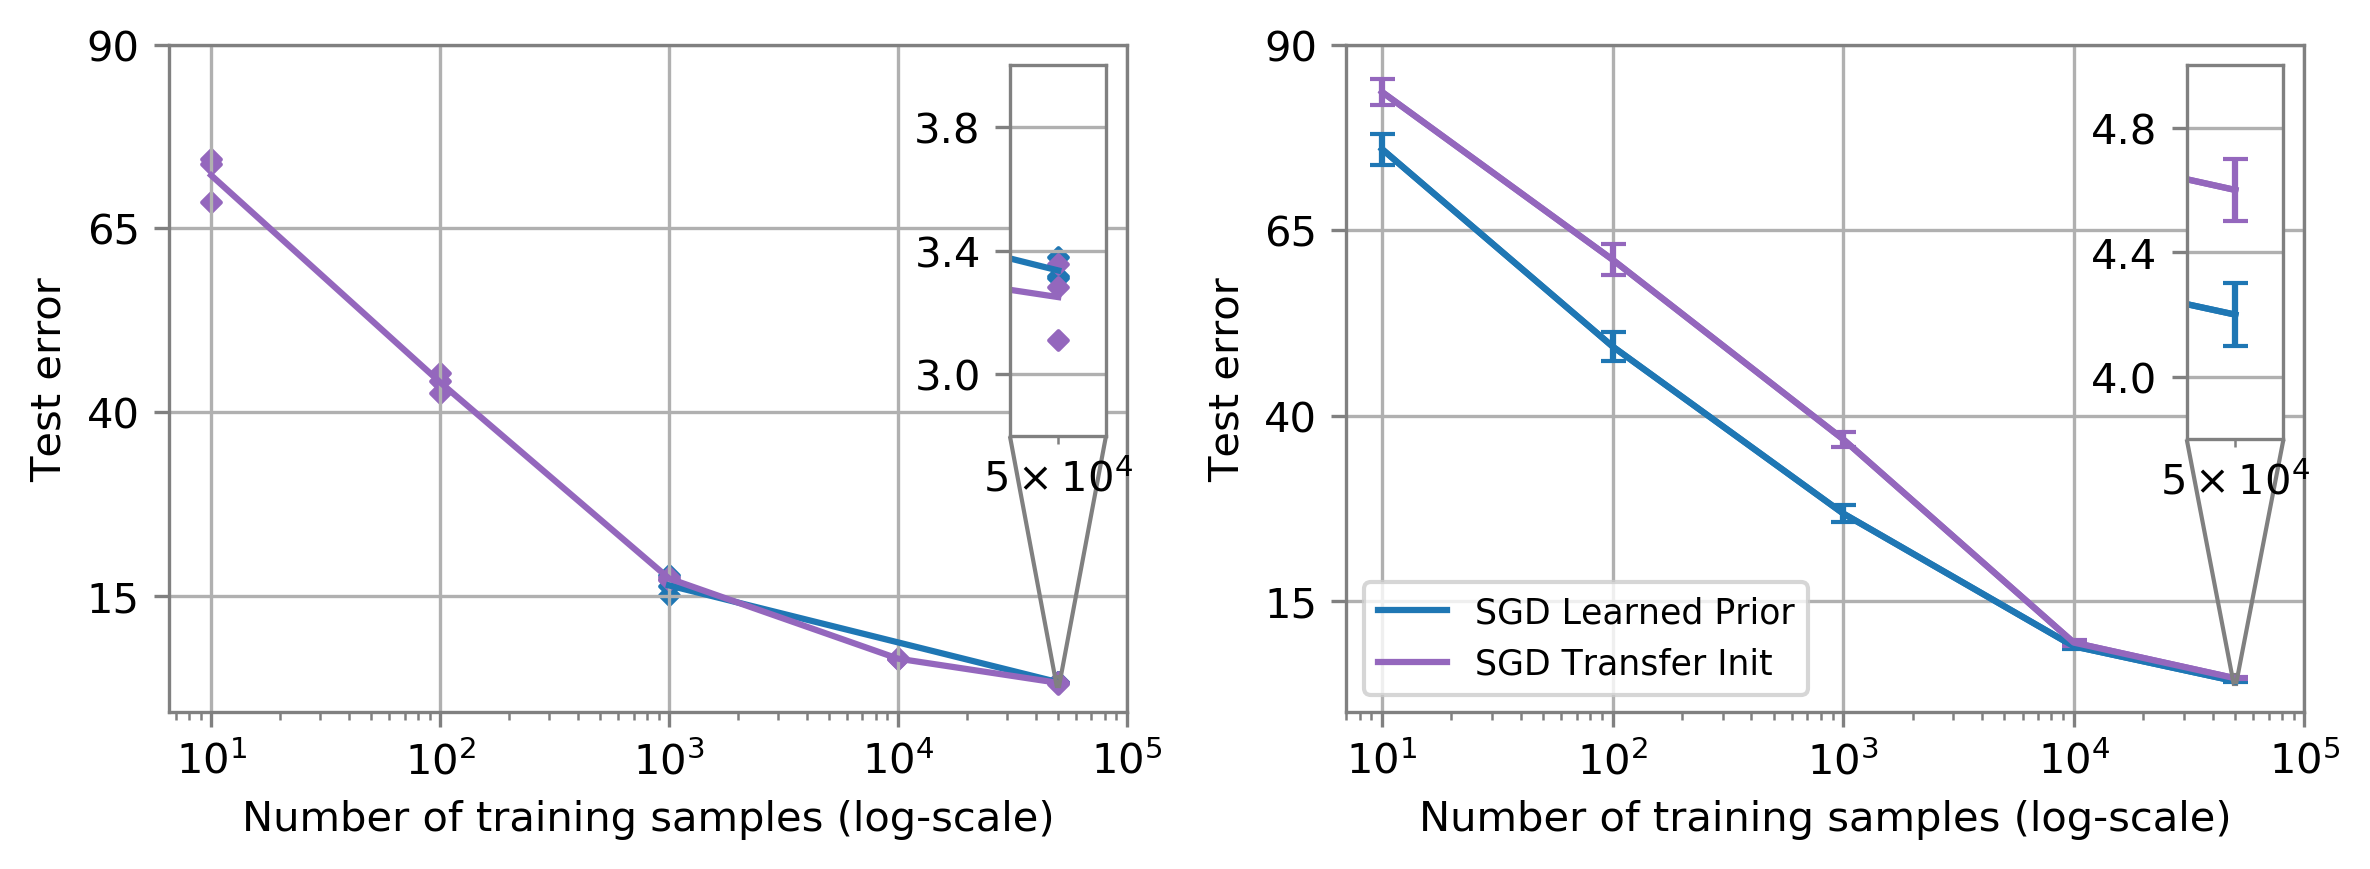

In [34]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), dpi=300)
axs[0].plot(grouped_results[grouped_results.method=='learned'].n, 100*(1-grouped_results[grouped_results.method=='learned'].test_acc_mean.values), label='SGD Learned Prior', color='#1f77b4')
axs[0].plot(grouped_results[grouped_results.method=='nonlearned'].n, 100*(1-grouped_results[grouped_results.method=='nonlearned'].test_acc_mean.values), label='SGD Transfer Init', color='#9467bd')
axs[0].scatter(results[results.method=='learned'].n, 100*(1-results[results.method=='learned'].test_acc.values), color='#1f77b4', marker='D', s=10)
axs[0].scatter(results[results.method=='nonlearned'].n, 100*(1-results[results.method=='nonlearned'].test_acc.values), color='#9467bd', marker='D', s=10)
# Zoomed section
axins = zoomed_inset_axes(axs[0], zoom=42, loc='upper right')
axins.plot(grouped_results[grouped_results.method=='learned'].n, 100*(1-grouped_results[grouped_results.method=='learned'].test_acc_mean.values), label='SGD Learned Prior', color='#1f77b4')
axins.plot(grouped_results[grouped_results.method=='nonlearned'].n, 100*(1-grouped_results[grouped_results.method=='nonlearned'].test_acc_mean.values), color='#9467bd')
axins.scatter(results[results.method=='learned'].n, 100*(1-results[results.method=='learned'].test_acc.values), color='#1f77b4', marker='D', s=10)
axins.scatter(results[results.method=='nonlearned'].n, 100*(1-results[results.method=='nonlearned'].test_acc.values), color='#9467bd', marker='D', s=10)
axins.set_xlim([49425, 50575])
axins.set_ylim([2.8, 4.0])
axins.set_yticks([3.0, 3.4, 3.8])
axins.set_xscale('log')
color_ax(axins)
mark_inset(axs[0], axins, loc1=3, loc2=4, color='gray')
# Formatting
axs[0].set_xscale('log')
color_ax(axs[0])
axs[0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
axs[0].set_yticks([15, 40, 65, 90])
axs[0].set_xlabel('Number of training samples (log-scale)')
axs[0].set_ylabel('Test error')
#axs[0].legend(loc='lower left', fontsize='small')
plot_figure_4a(axs[1])
fig.tight_layout()
plt.show()